# Imports


In [16]:
import numpy as np 
import pandas as pd 
import os

import matplotlib.pyplot as plt
import csv
import itertools
import collections

import pywt
from scipy import stats

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Conv1D, AvgPool1D, Flatten, Dense, Dropout, Softmax,MaxPool1D,MaxPooling1D
from keras.optimizers import Adam 
from keras.utils import to_categorical
from keras.utils import plot_model
from keras import regularizers


%matplotlib inline

# matplotlib Settings

In [17]:
plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 

# Methods Definitions

In [18]:
def denoise(data): 
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    datarec = pywt.waverec(coeffs, 'sym4')
    
    return datarec


# Variables Definitions

* **N (Normal):** The "N" represents a normal heartbeat or cardiac complex. It indicates that the electrical activity of the heart is within the normal range, and there are no abnormalities or irregularities in the heart rhythm.
* **L (Left bundle branch block):** An "L" complex indicates the presence of a left bundle branch block. This is an abnormality in the electrical conduction system of the heart, where the electrical signals do not travel normally through the left bundle branch. It can affect the timing and coordination of ventricular contractions.
* **R (Right bundle branch block):** An "R" complex indicates a right bundle branch block. Similar to left bundle branch block, this signifies an abnormality in the electrical conduction system involving the right bundle branch.
* **A (Atrial premature beat):** An "A" complex represents an atrial premature beat, which is an early contraction originating in the atria (upper chambers of the heart) before the next expected normal heartbeat.
* **V (Ventricular premature beat):** A "V" complex represents a ventricular premature beat, which is an early contraction originating in the ventricles (lower chambers of the heart) before the next expected normal heartbeat.


In [19]:
path = './mitbih_database/'
window_size = 1000
maximum_counting = 10000

classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

In [20]:

filenames = next(os.walk(path))[2]

records = list()
annotations = list()
filenames.sort()

In [21]:
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)
print(records[0])
print(annotations[0])

./mitbih_database/100.csv
./mitbih_database/100annotations.txt


# Data Extraction and Preprocessing

<>:13: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:21: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:29: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:53: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:13: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:21: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:29: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:53: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\visha\AppData\Local\Temp\ipykernel_1880\2234930621.py:13: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if r is 1:
C:\Users\visha\AppData\Local\Temp\ipykernel_1880\2234930621.py:21: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if r is 1:
C:\Users\visha\AppData\Local\Temp\ipykernel_1880\2234930621.py:29: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if r is 1:
C:\Users\visha\AppData\Local\Temp\ipykernel_1880\2234930621.py:53: SyntaxWarning: "is" with a liter

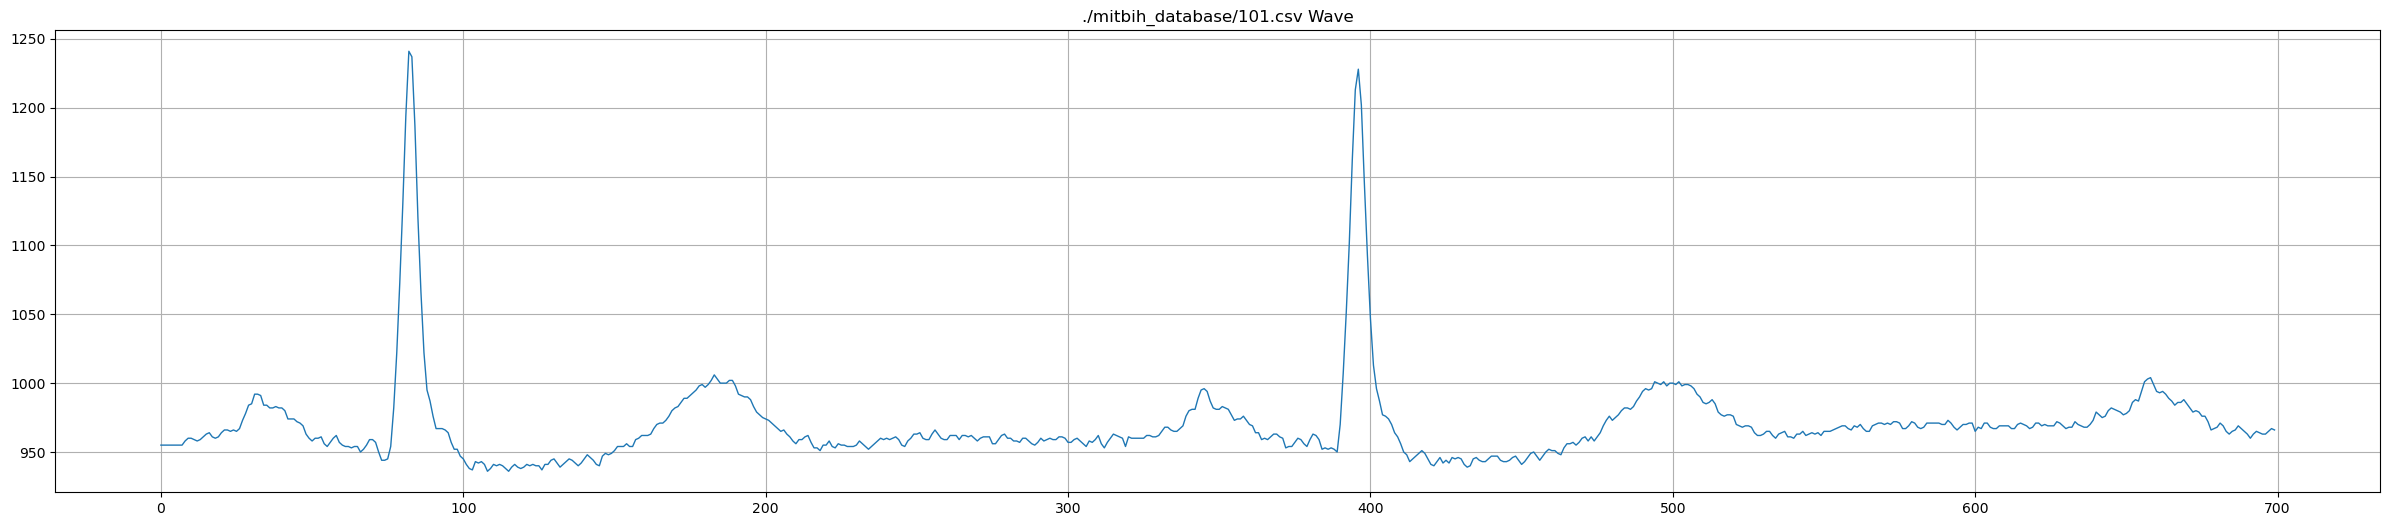

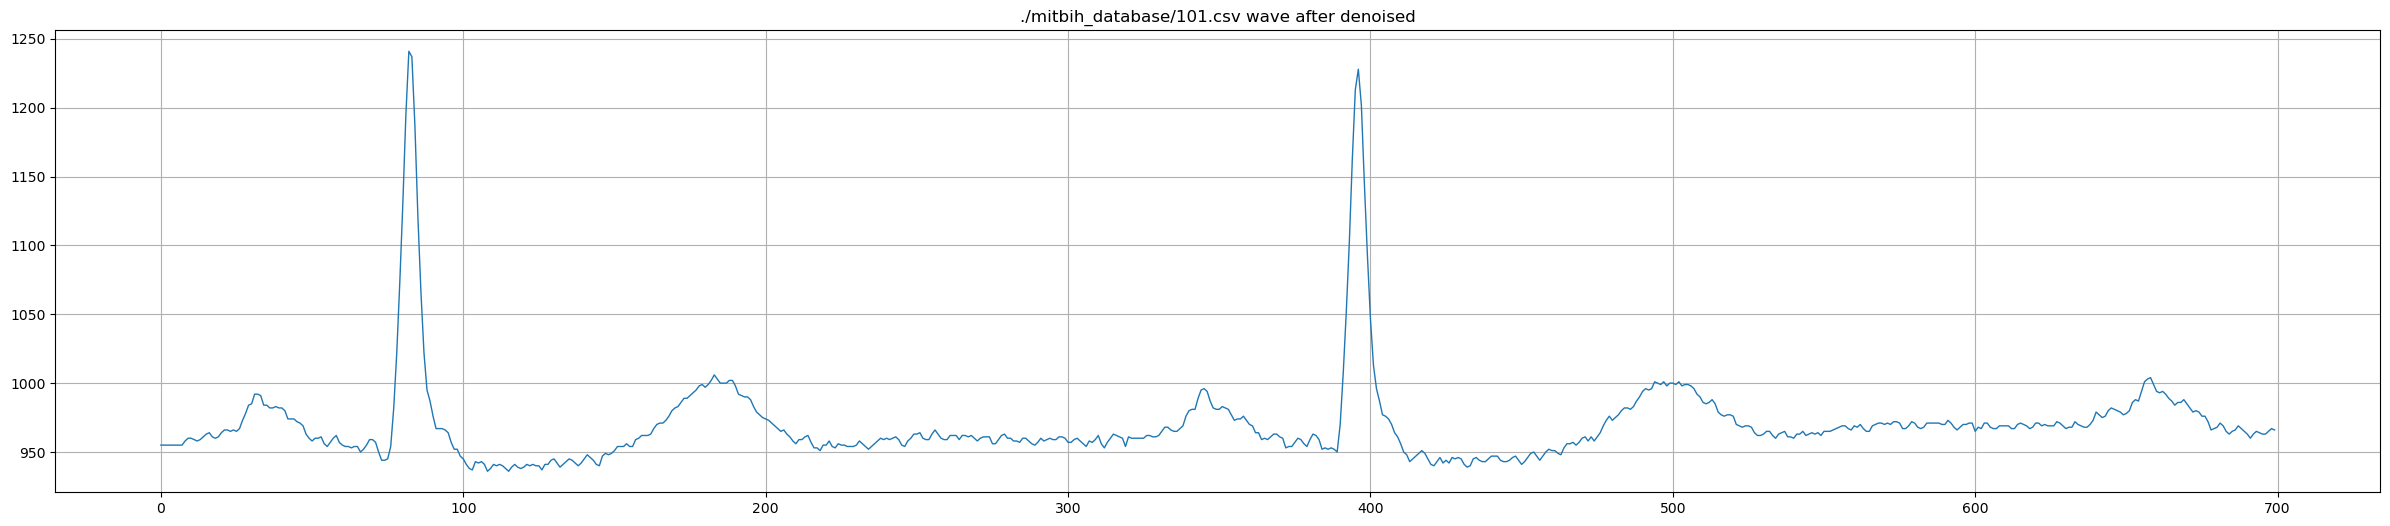

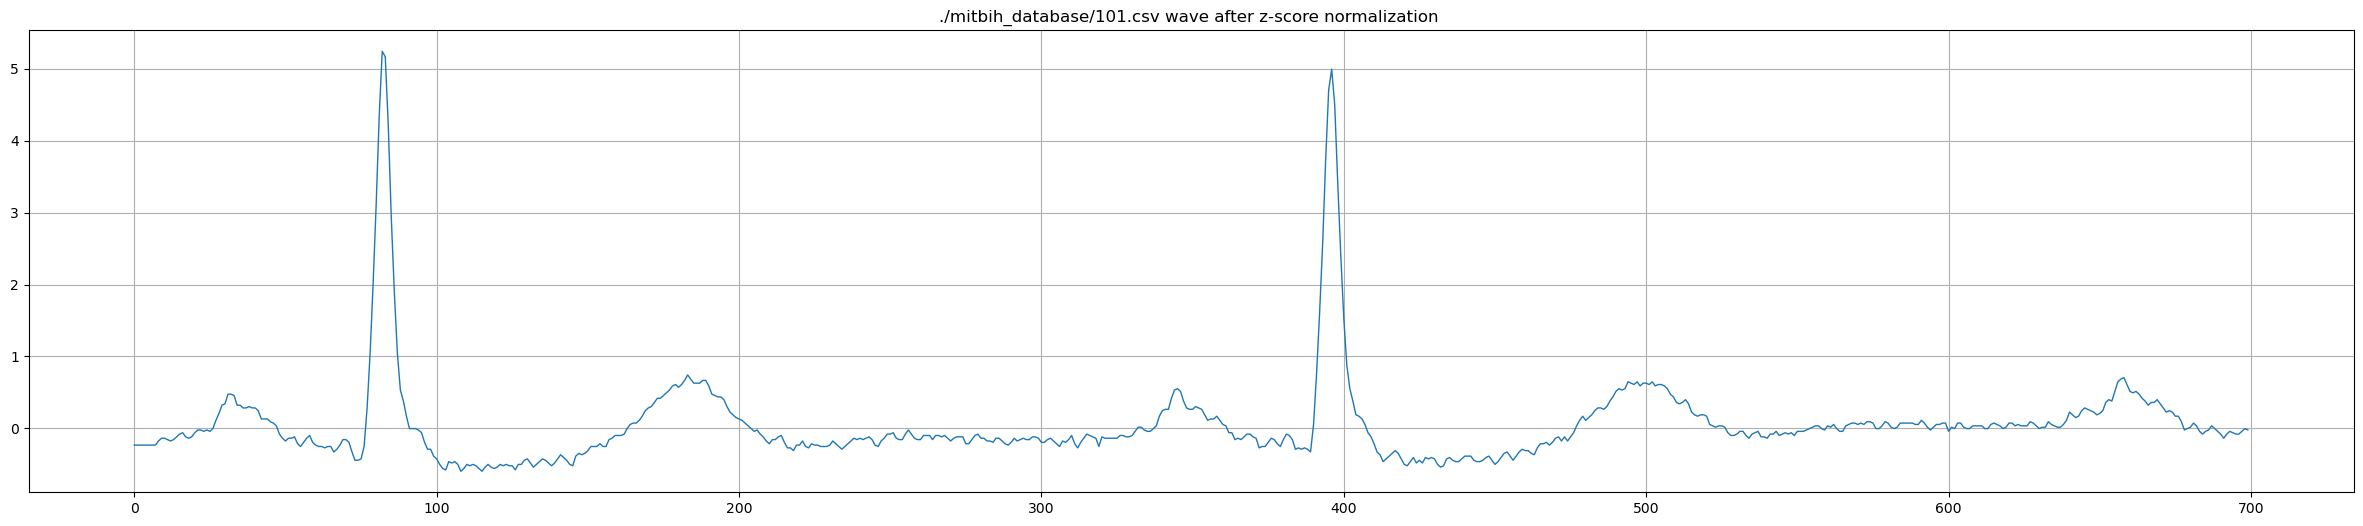

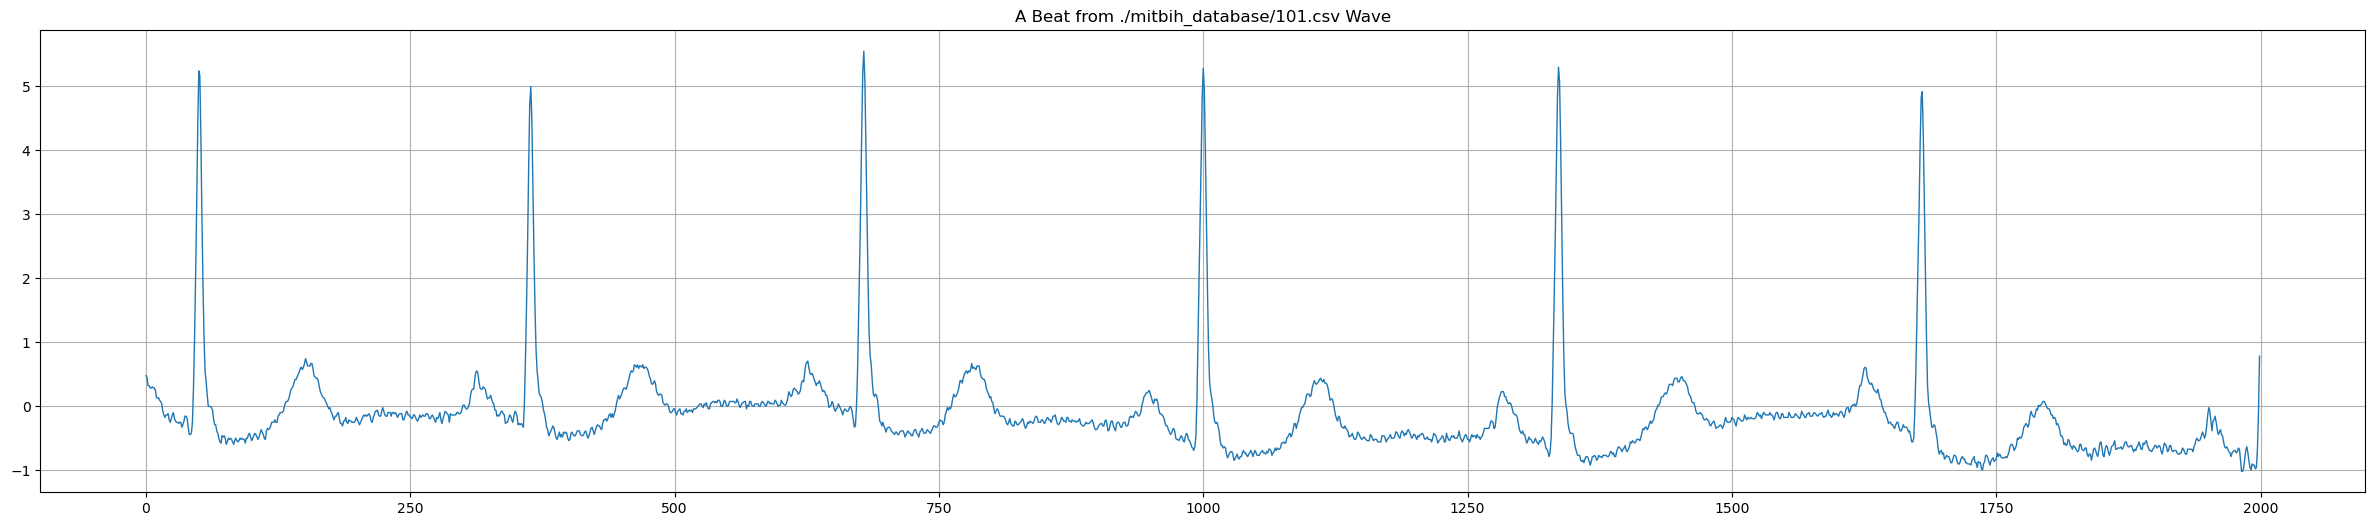

(99754, 2000) (99754,)


In [22]:
# Records
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1

    if r is 1:

        plt.title(records[1] + " Wave")
        plt.plot(signals[0:700])
        plt.show()
        

    if r is 1:

        plt.title(records[1] + " wave after denoised")
        plt.plot(signals[0:700])
        plt.show()
        
    signals = stats.zscore(signals)

    if r is 1:
  
        plt.title(records[1] + " wave after z-score normalization ")
        plt.plot(signals[0:700])
        plt.show()

    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): 
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]     ## REPLACE WITH R-PEAK DETECTION
                    # Plot an example to a beat    
                    if r is 1 and not example_beat_printed: 
                        plt.title("A Beat from " + records[1] + " Wave")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)

print(np.shape(X), np.shape(y))

In [23]:
print(count_classes)

[75052, 8075, 7259, 2546, 7130]


In [24]:
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])
#         X[i].append(y[i])

print(np.shape(X))


(99754, 2001)


In [25]:
print(X[1][360])

0.0067234989726539605


# Classes Distribution

0.0    74815
1.0     8053
2.0     7235
4.0     7114
3.0     2537
Name: 2000, dtype: int64


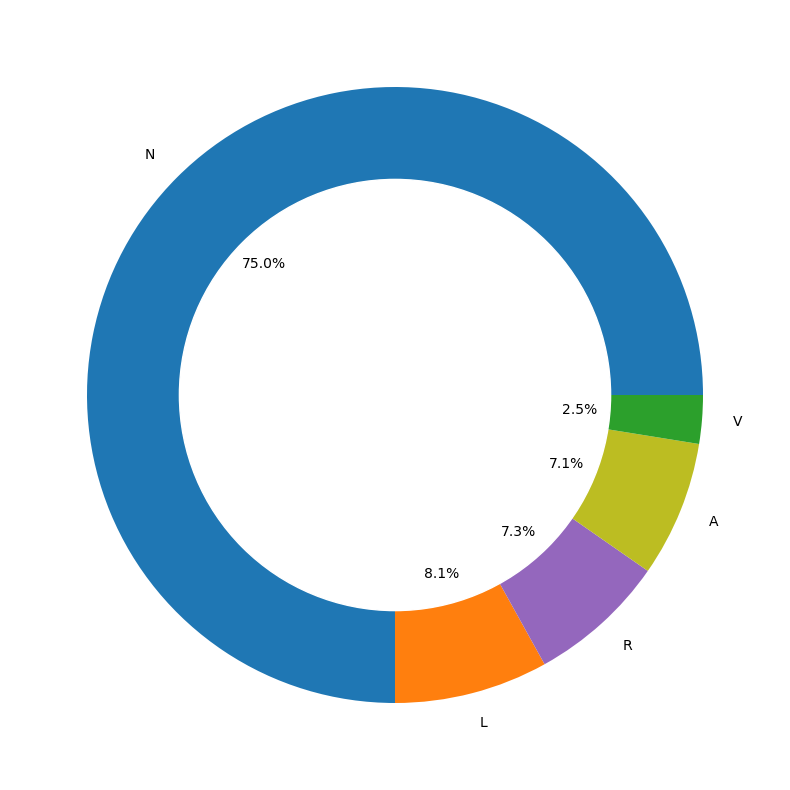

In [26]:
X_train_df = pd.DataFrame(X)
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [27]:
X_train_df.shape

(99754, 2001)

# Rebalancing Classes

In [33]:
df_1=X_train_df[X_train_df[X_train_df.shape[1]-1]==1]
df_2=X_train_df[X_train_df[X_train_df.shape[1]-1]==2]
df_3=X_train_df[X_train_df[X_train_df.shape[1]-1]==3]
df_4=X_train_df[X_train_df[X_train_df.shape[1]-1]==4]
# df_5=X_train_df[X_train_df[X_train_df.shape[1]-1]==5]
df_0=(X_train_df[X_train_df[X_train_df.shape[1]-1]==0]).sample(n=5000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=5000,random_state=122)
df_2_upsample=resample(df_2,replace=True,n_samples=5000,random_state=123)
df_3_upsample=resample(df_3,replace=True,n_samples=5000,random_state=124)
df_4_upsample=resample(df_4,replace=True,n_samples=5000,random_state=125)
# df_5_upsample=resample(df_5,replace=True,n_samples=5000,random_state=126)

# X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample,df_5_upsample])
X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

0.0    5000
1.0    5000
2.0    5000
3.0    5000
4.0    5000
Name: 2000, dtype: int64


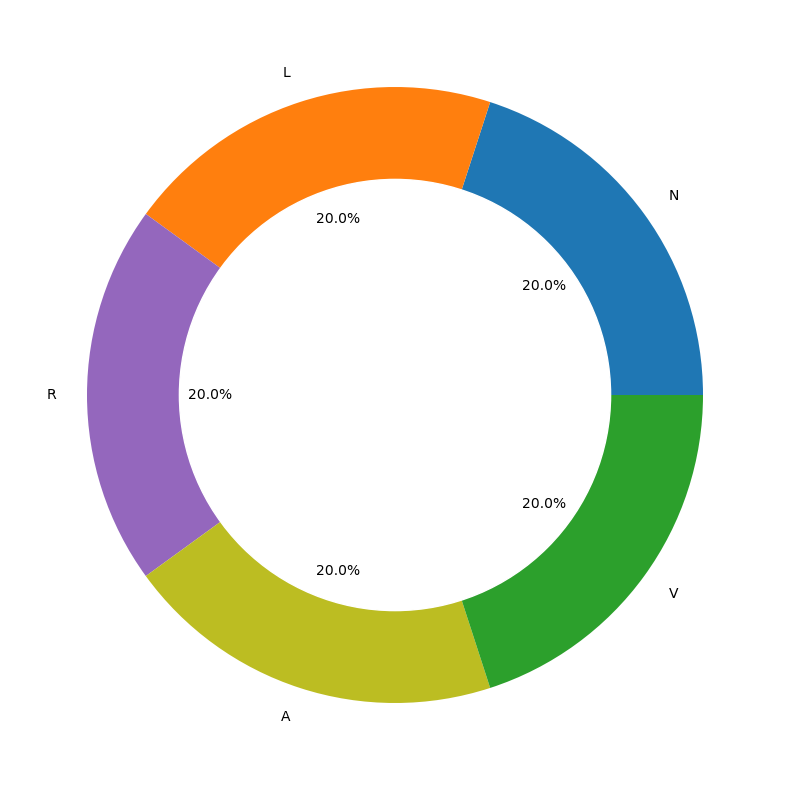

In [34]:
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

# Train-Test Split

In [35]:
train, test = train_test_split(X_train_df, test_size=0.20)

print("X_train : ", np.shape(train))
print("X_test  : ", np.shape(test))

X_train :  (20000, 2001)
X_test  :  (5000, 2001)


In [36]:
target_train=train[train.shape[1]-1]
target_test=test[test.shape[1]-1]
train_y=to_categorical(target_train)
test_y=to_categorical(target_test)
print(np.shape(train_y), np.shape(test_y))

(20000, 5) (5000, 5)


In [37]:
train

,0,1,2,3,4,5,6,7,8,9,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000
31384,0.357625,0.404349,0.392668,0.357625,0.369306,0.299218,0.264175,0.182406,0.205769,0.182406,...,-0.611916,-0.658641,-0.670322,-0.728728,-0.775453,-0.763772,-0.752090,-0.763772,-0.740409,2.0
64465,1.195788,1.256156,1.165604,1.090144,0.999592,0.878856,0.848672,0.758120,0.682660,0.577016,...,0.244992,0.260084,0.260084,0.169532,0.094072,0.094072,0.109164,0.154440,0.109164,2.0
57563,-0.444885,-0.444885,-0.434519,-0.496716,-0.507083,-0.496716,-0.475984,-0.465618,-0.507083,-0.538181,...,-0.196095,-0.196095,-0.196095,-0.164997,-0.216828,-0.268659,-0.258293,-0.206462,-0.175363,4.0
46624,-0.489934,-0.540350,-0.523544,-0.540350,-0.557155,-0.540350,-0.506739,-0.506739,-0.489934,-0.540350,...,-0.338685,-0.338685,-0.389101,-0.389101,-0.389101,-0.422712,-0.355491,-0.305075,-0.372296,0.0
54619,0.355598,0.369716,0.355598,0.383834,0.383834,0.426189,0.454426,0.454426,0.468544,0.482663,...,0.059112,0.030876,0.030876,0.002639,0.044994,0.044994,0.073231,0.030876,0.016757,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77215,-0.500912,-0.485216,-0.500912,-0.516609,-0.516609,-0.516609,-0.548002,-0.532305,-0.469519,-0.453823,...,-0.265464,-0.296857,-0.249767,-0.265464,-0.265464,-0.234071,-0.218374,-0.171285,-0.139891,0.0
58717,-0.821737,-0.728492,-0.765790,-0.709843,-0.616597,-0.523352,-0.448756,-0.392809,-0.411458,-0.392809,...,-0.038477,-0.113073,-0.224967,-0.318212,-0.411458,-0.430107,-0.280914,-0.150371,-0.131722,3.0
40352,0.201716,0.201716,0.212542,0.190890,0.169237,0.147585,0.136759,0.125933,0.136759,0.158411,...,0.364109,0.374936,0.396588,0.364109,0.364109,0.342457,0.288326,0.266673,0.255847,2.0
14409,-0.560231,-0.480105,-0.460073,-0.470089,-0.470089,-0.450057,-0.430026,-0.420010,-0.420010,-0.450057,...,0.060746,0.060746,0.100808,0.090793,0.080777,0.050730,0.060746,0.090793,0.120840,1.0


In [38]:
train_x = train.iloc[:,:train.shape[1]-1].values
test_x = test.iloc[:,:test.shape[1]-1].values
train_x = train_x.reshape(len(train_x), train_x.shape[1],1)
test_x = test_x.reshape(len(test_x), test_x.shape[1],1)
print(np.shape(train_x), np.shape(test_x))
print(np.shape(train_y),np.shape(test_y))

(20000, 2000, 1) (5000, 2000, 1)
(20000, 5) (5000, 5)


## Building the Model Architecture


In [39]:
# Instanciate an empty model
model = Sequential()
model.add(Conv1D(filters=16, kernel_size=13, padding='same', activation='relu',input_shape=train_x[0].shape))
model.add(MaxPool1D(pool_size=3, strides=2))
model.add(Conv1D(filters=32, kernel_size=15, padding='same', activation='relu'))
model.add(MaxPool1D(pool_size=3, strides=2))
model.add(Conv1D(filters=64, kernel_size=17, padding='same', activation='relu'))
model.add(MaxPool1D(pool_size=3, strides=2))
model.add(Conv1D(filters=128, kernel_size=19, padding='same', activation='relu'))
model.add(MaxPool1D(pool_size=3, strides=2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(35,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))
model.add(Dense(5,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))
model.add(Softmax())
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2000, 16)          224       
                                                                 
 max_pooling1d (MaxPooling1  (None, 999, 16)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 999, 32)           7712      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 499, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 499, 64)           34880     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 249, 64)          

## Compiling the model

In [40]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

## Fitting the model

In [41]:
history = model.fit(train_x, train_y, batch_size=75, epochs=50, verbose=1, validation_data=(test_x, test_y))

Epoch 1/50


267/267 [==============================] - 30s 102ms/step - loss: 0.3056 - accuracy: 0.9007 - val_loss: 0.0909 - val_accuracy: 0.9764
Epoch 2/50
267/267 [==============================] - 27s 100ms/step - loss: 0.0882 - accuracy: 0.9779 - val_loss: 0.0678 - val_accuracy: 0.9850
Epoch 3/50
267/267 [==============================] - 27s 101ms/step - loss: 0.0670 - accuracy: 0.9844 - val_loss: 0.0534 - val_accuracy: 0.9874
Epoch 4/50
267/267 [==============================] - 26s 99ms/step - loss: 0.0518 - accuracy: 0.9890 - val_loss: 0.0607 - val_accuracy: 0.9860
Epoch 5/50
267/267 [==============================] - 26s 96ms/step - loss: 0.0542 - accuracy: 0.9882 - val_loss: 0.0524 - val_accuracy: 0.9898
Epoch 6/50
267/267 [==============================] - 25s 95ms/step - loss: 0.0441 - accuracy: 0.9922 - val_loss: 0.0544 - val_accuracy: 0.9900
Epoch 7/50
267/267 [==============================] - 25s 95ms/step - loss: 0.0499 - accuracy: 0.9919 - val_loss: 0.0523 - val_accu

**Plotting the loss convergence**

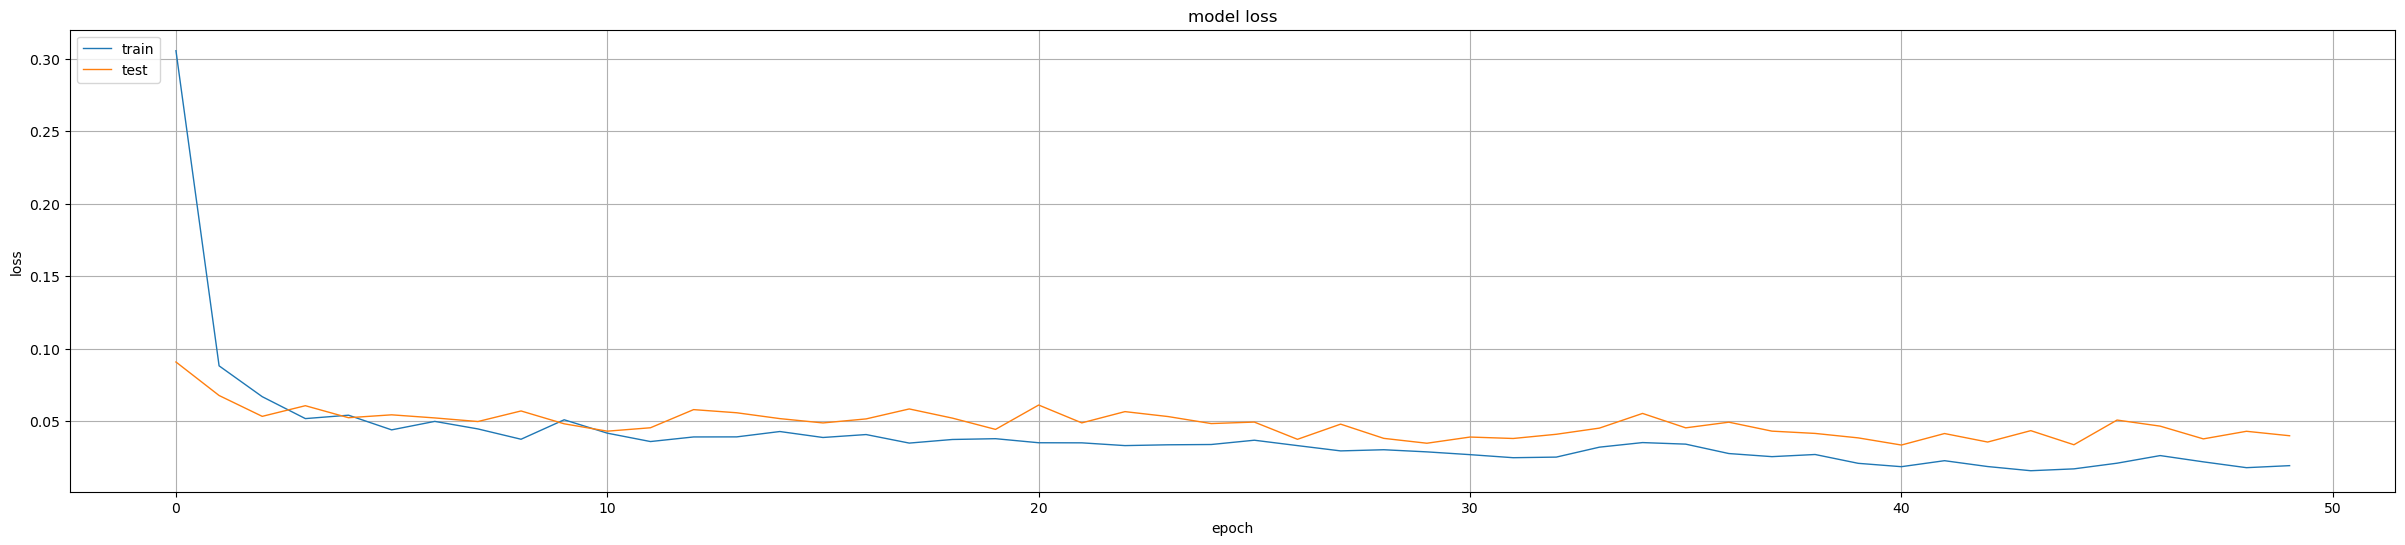

In [42]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Plotting accuracy**

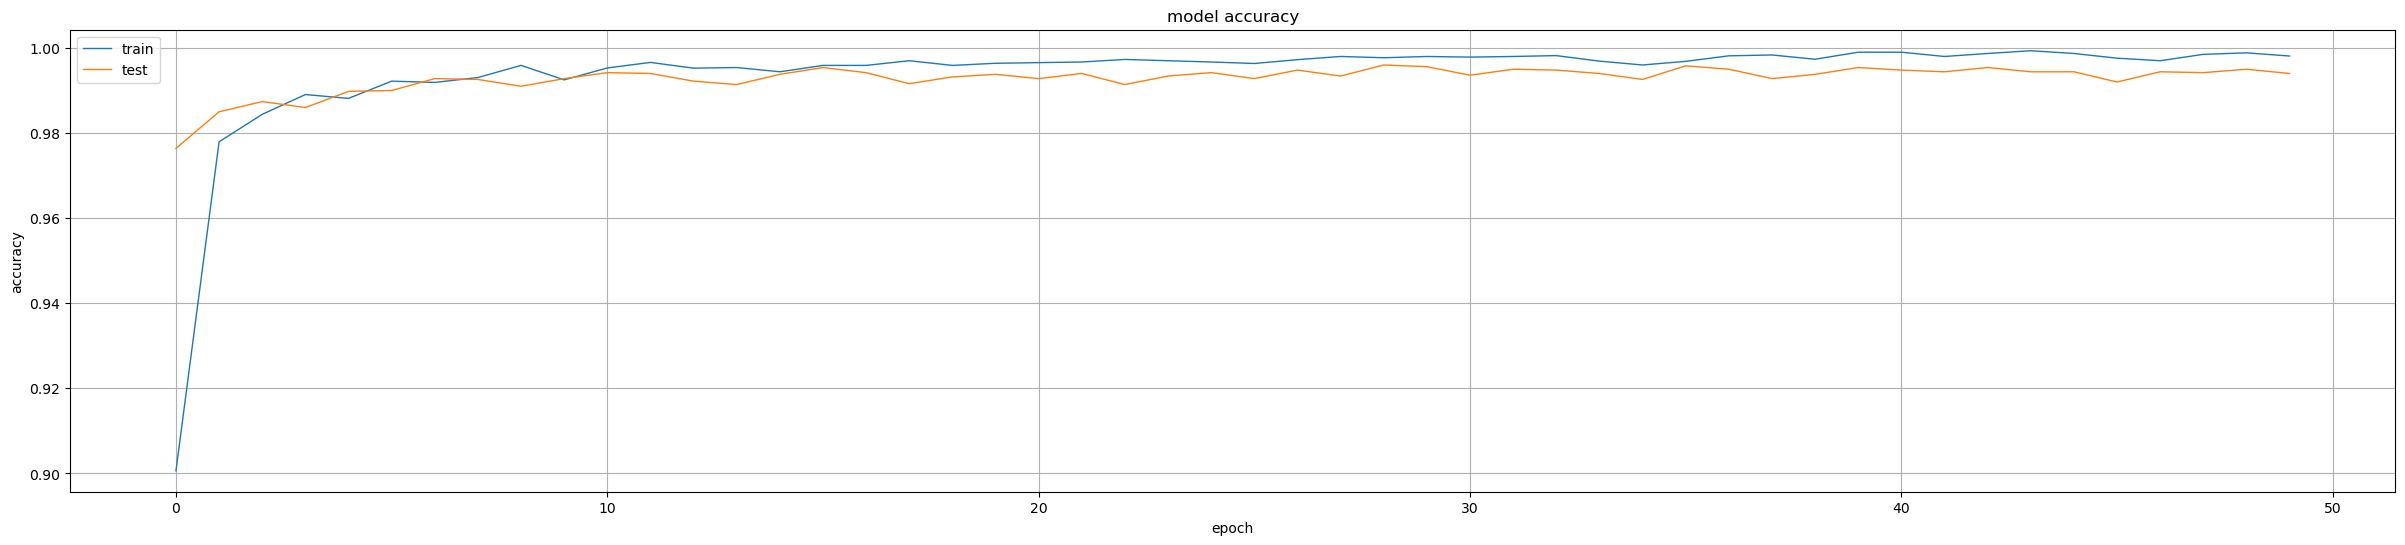

In [43]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [51]:
model.save('arryhtmia-classification')

INFO:tensorflow:Assets written to: arryhtmia-classification\assets


INFO:tensorflow:Assets written to: arryhtmia-classification\assets


## Finding the loss and accuracy of the model

In [52]:
score = model.evaluate(test_x, test_y)

print('Test Loss:', score[0])
print('Test accuracy:', score[1])

157/157 [==============================] - 2s 13ms/step - loss: 0.0400 - accuracy: 0.9940
Test Loss: 0.040009599179029465
Test accuracy: 0.9940000176429749


157/157 [==============================] - 2s 12ms/step


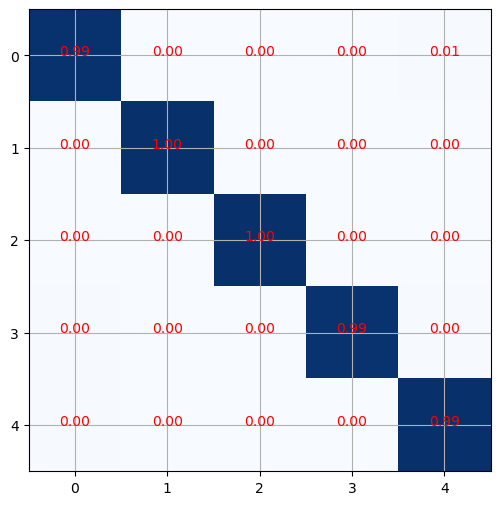

In [46]:
from sklearn.metrics import f1_score, confusion_matrix
pred_y = model.predict(test_x)
cm = confusion_matrix(test_y.argmax(axis=1), pred_y.argmax(axis=1))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

for i in range(cm.shape[1]):
    for j in range(cm.shape[0]):
        plt.text(j, i, format(cm[i, j], '.2f'), horizontalalignment="center", color="red")


plt.imshow(cm, cmap=plt.cm.Blues)

In [47]:


print("The distribution of test set labels")
print(test[X_train_df.shape[1]-1].value_counts())

print('F1_score = ', f1_score(test_y.argmax(axis=1), pred_y.argmax(axis=1), average = 'macro'))


The distribution of test set labels
0.0    1037
1.0    1022
3.0    1011
2.0     983
4.0     947
Name: 2000, dtype: int64
F1_score =  0.9939807297568306


# Notations
* **N (Normal):** The "N" represents a normal heartbeat or cardiac complex. It indicates that the electrical activity of the heart is within the normal range, and there are no abnormalities or irregularities in the heart rhythm.
* **L (Left bundle branch block):** An "L" complex indicates the presence of a left bundle branch block. This is an abnormality in the electrical conduction system of the heart, where the electrical signals do not travel normally through the left bundle branch. It can affect the timing and coordination of ventricular contractions.
* **R (Right bundle branch block):** An "R" complex indicates a right bundle branch block. Similar to left bundle branch block, this signifies an abnormality in the electrical conduction system involving the right bundle branch.
* **A (Atrial premature beat):** An "A" complex represents an atrial premature beat, which is an early contraction originating in the atria (upper chambers of the heart) before the next expected normal heartbeat.
* **V (Ventricular premature beat):** A "V" complex represents a ventricular premature beat, which is an early contraction originating in the ventricles (lower chambers of the heart) before the next expected normal heartbeat.

Actual label:  V
Model prediction :  V  with probability  1.0


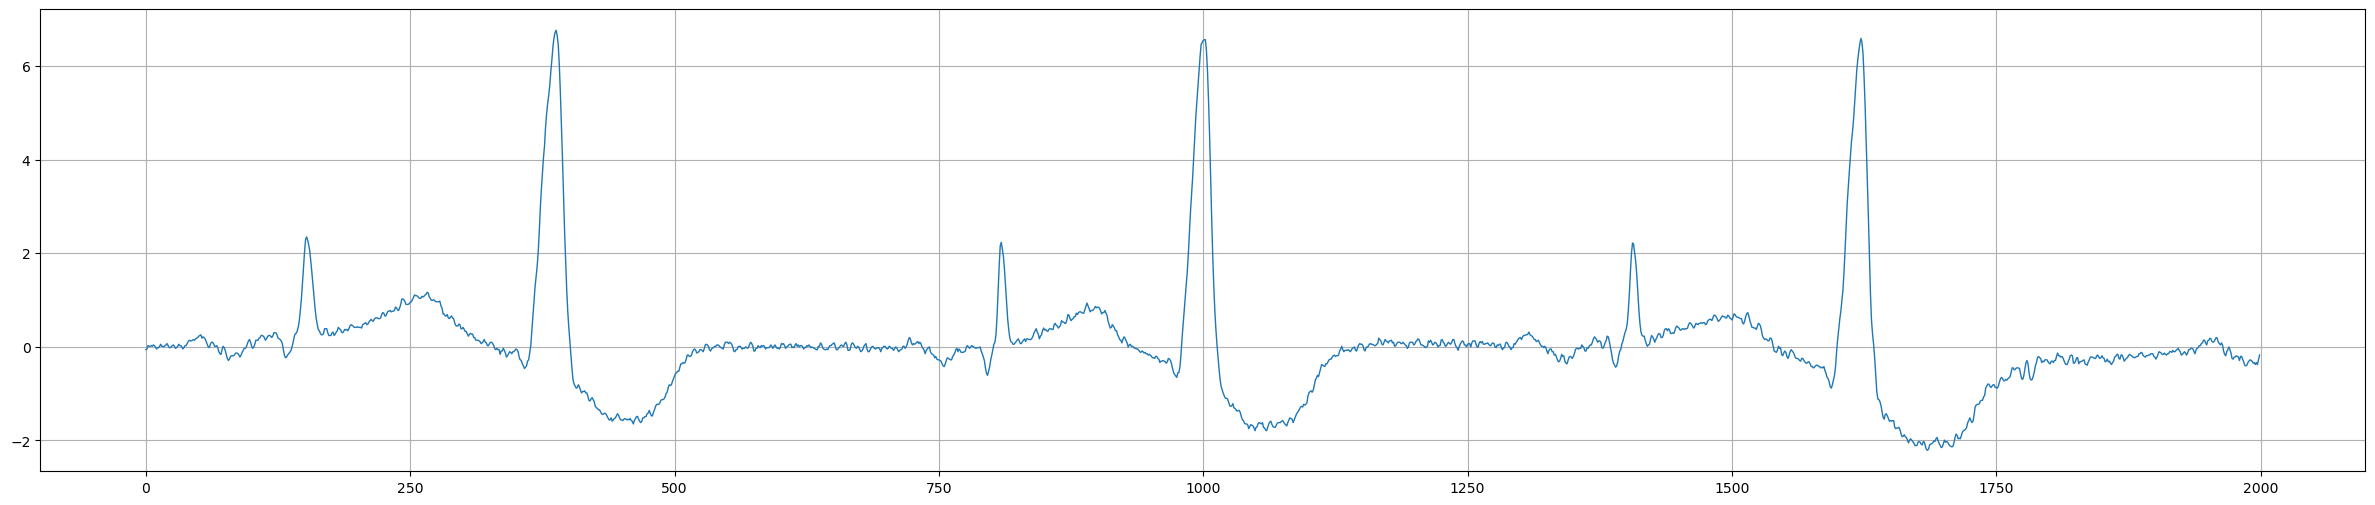

In [48]:
import random
i = random.randint(0, len(test_x)-1)

output = model(np.expand_dims(test_x[i], 0))

pred = output.numpy()[0]

plt.plot(test_x[i])

print("Actual label: ", classes[np.argmax(test_y[i])])
print("Model prediction : ", classes[np.argmax(pred)], " with probability ", pred[np.argmax(pred)])